# Binary Adder using RNN

- The idea is referenced from the link: https://iamtrask.github.io/2015/11/15/anyone-can-code-lstm/

## Model

In [1]:
import copy, numpy as np

In [2]:
np.random.seed(0)

# compute sigmoid nonlinearity
def sigmoid(x):
    output = 1/(1+np.exp(-x))
    return output

# convert output of sigmoid function to its derivative
def sigmoid_output_to_derivative(output):
    return output*(1-output)

In [3]:
# Variables
alpha = 0.1 # Training Rate
input_dim = 2
hidden_dim = 16
output_dim = 1

In [4]:
# Neural Network Weights
synapse_0 = 2*np.random.random((input_dim,hidden_dim)) - 1
synapse_1 = 2*np.random.random((hidden_dim,output_dim)) - 1
synapse_h = 2*np.random.random((hidden_dim,hidden_dim)) - 1

# Layers
layer_2_deltas = list()
layer_1_values = list()

## Prepare Dataset

- Maximum binary length is set to 7, since I would like to fit result data in 8 digit array.

In [5]:
# Dataset
def generate_dataset(max_features = 30000, ratio = 0.2, binary_length = 7):
    nTrain, nTest = int(max_features*(1-ratio)), int(max_features * ratio)
    upper_lim = pow(2,binary_length) # actual upper value is 1 less.
    r_train_set = np.random.randint(upper_lim, size=(nTrain,2))
    r_test_set = np.random.randint(upper_lim, size=(nTest,2))

    # Dictionary of binary array
    int2bin = np.unpackbits(
        np.arange(2*upper_lim).astype(np.uint8)[:, None], axis=-1).tolist()
    for i in range(len(int2bin)): int2bin[i].reverse()
    
    # Training Set
    X_train, y_train = [],[]
    for a, b in r_train_set:
        X_train.append((int2bin[a],int2bin[b]))
        y_train.append(int2bin[a+b])
        
    X_test, y_test = [],[]
    for a, b in r_test_set:
        X_test.append((int2bin[a],int2bin[b]))
        y_test.append(int2bin[a+b])
    return (X_train, y_train), (X_test, y_test)
    
(X_train, y_train), (X_test, y_test) = generate_dataset()

### Visualize Data

In [6]:
# Empty

([1, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 1, 1, 1, 0, 0])
[1, 0, 1, 0, 0, 0, 1, 0]
([0, 1, 0, 0, 0, 1, 1, 0], [1, 0, 0, 0, 0, 1, 1, 0])
[1, 1, 0, 0, 0, 0, 1, 1]


## Training

In [7]:
# Forward-Propagation
def training(a, b, c):
    d = []
    err = 0
    
    for position in range(len(a)):
        # Input Layer
        X, y = np.array( [a[position], b[position]] ), np.array([[c[position]]]).T
        
        # hidden layer (input ~+ prev_hidden)
        layer_1 = sigmoid(np.dot(X,synapse_0) + np.dot(layer_1_values[-1],synapse_h)) # add previous hidden layer

        # output layer (new binary representation)
        layer_2 = sigmoid(np.dot(layer_1,synapse_1))

        # Output Interpretation
        d.append(int(np.round(layer_2[0])))
        
        # Loss Function
        layer_2_error = y - layer_2
        layer_2_deltas.append((layer_2_error)*sigmoid_output_to_derivative(layer_2))
        err += np.abs(layer_2_error[0])[0] * pow(2,position)
        
        # Save hidden layer
        layer_1_values.append(copy.deepcopy(layer_1))
    
    # return error and result
    return d, err
          

In [8]:
# Back Propagation
def bp():
    global synapse_h, synapse_1, synapse_0
    synapse_0_update = np.zeros((input_dim,hidden_dim))
    synapse_1_update = np.zeros((hidden_dim, output_dim))
    synapse_h_update = np.zeros((hidden_dim, hidden_dim))
    
    future_layer_1_delta = np.zeros(hidden_dim)
    
    for position in range(len(a)):
        X = np.array([[a[-position],b[-position]]]).T
        layer_1 = layer_1_values[-position-1]
        prev_layer_1 = layer_1_values[-position-2]
        
        # error @ output layer
        layer_2_delta = layer_2_deltas[-position-1]
        # error @ hidden layer
        layer_1_delta = (future_layer_1_delta.dot(synapse_h.T) + layer_2_delta.dot(synapse_1.T)) * sigmoid_output_to_derivative(layer_1)

        # update
        synapse_1_update += np.atleast_2d(layer_1).T.dot(layer_2_delta)
        synapse_h_update += np.atleast_2d(prev_layer_1).T.dot(layer_1_delta)
        synapse_0_update += X.dot(layer_1_delta)
        
        future_layer_1_delta = layer_1_delta
    
    synapse_0 += synapse_0_update * alpha
    synapse_1 += synapse_1_update * alpha
    synapse_h += synapse_h_update * alpha    

In [9]:
# Iterate Through Dataset
epoch = 10
history = []
for e in range(epoch):
    for j in range(len(X_train)):
        a,b = X_train[j]
        c = y_train[j]

        # initlize layer
        layer_2_deltas = list()
        layer_1_values = list()
        layer_1_values.append(np.zeros(hidden_dim))

        # Forward-Propagation
        d, err = training(a, b, c)

        # Back Propagation
        bp()
        
        if j % 100 == 0: history.append(err)

    # Print out progress
    print("------------ epoch : " , e)
    print("Error: ", err)

print(" Finished ")

------------ epoch :  0
Error:  19.572331664169184
------------ epoch :  1
Error:  8.657681052181012
------------ epoch :  2
Error:  5.081456007729805
------------ epoch :  3
Error:  8.03514063362475
------------ epoch :  4
Error:  4.863780178252414
------------ epoch :  5
Error:  2.3617391309453195
------------ epoch :  6
Error:  2.2640943043253854
------------ epoch :  7
Error:  2.189999120470585
------------ epoch :  8
Error:  2.04690087963232
------------ epoch :  9
Error:  1.8756461447106891
 Finished 


## Result

Text(0.5,1,'error throughout training')

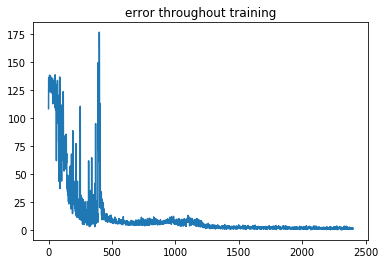

In [10]:
# Graph Error
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history)
plt.title('error throughout training')

In [11]:
# Prediction and Error
total_err = 0.0
nTestData = len(X_test)
errorDist = []
for j in range(nTestData):
    a,b = X_test[j]
    c = y_test[j]

    # initlize layer
    layer_2_deltas = list()
    layer_1_values = list()
    layer_1_values.append(np.zeros(hidden_dim))

    # Forward-Propagation
    d, err = training(a, b, c)
    errorDist.append(err)
    
    total_err += err/nTestData
    
# Print out progress
print("Error: ", total_err)

Error:  1.9138404061172607


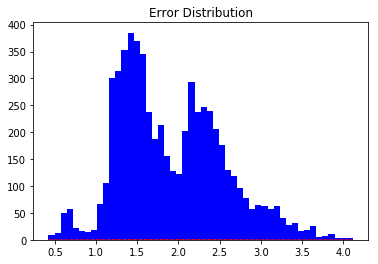

In [12]:
from matplotlib.pyplot import mlab

n, bins, patches = plt.hist(errorDist, bins=50, facecolor='blue', histtype='bar')
mu = np.mean(errorDist)
sigma = np.std(errorDist)

# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)

plt.title('Error Distribution')

plt.show()